# Capstone Project - The Battle of the Neighborhoods - Where to Build a BBQ Restaurant in Manhattan, New York City?
### Applied Data Science Capstone

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a barbecue restaurant. Specifically, this report will be targeted to stakeholders interested in opening a barbecue restaurant in **Manhattan**, New York.

In addition to Barbacue, there are also an abundance of restaurants and bars in the city. In order to solve this, we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with limited barbecue restaurants** in order to limit competition.

We will use our data science expertise to generate a few of the most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that the best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on the definition of our problem, factors that will influence our decision are:
* number of existing barbecue restaurants in the neighborhood
* number of and other similar restaurants in the neighborhood, if any

I decided to use a the following New York City data set which contains each borough and all neighborhoods within each borough along with their latitude and longitude coordinates.

https://geo.nyu.edu/catalog/nyu_2451_34572

The following data sources will be needed to extract/generate the required information:
* Number of restaurants, what type they are, and location in every neighborhood will be obtained using **Foursquare API**
* We will use the **geocoder from the geopy library** to obtain latitude and longitude information from venues of interest
* **Folium Maps** will be used to display chloropleth maps of restaurant ratings in each borough

First, we import and install all of the necessary dependencies for obtaining our dataset

In [1]:

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

#### We then enter in our Foursquare credentials

In [2]:
CLIENT_ID = '53CGMWQFD4N41RHRIHGJVUUBWJRFATUDXJSTKKPC20VHCKQH' # your Foursquare ID
CLIENT_SECRET = 'SMQP5O4LRDDMVSTRIBSINUWEEZTVPHJ0QB051A2PQTZPW52W' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 150
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 53CGMWQFD4N41RHRIHGJVUUBWJRFATUDXJSTKKPC20VHCKQH
CLIENT_SECRET:SMQP5O4LRDDMVSTRIBSINUWEEZTVPHJ0QB051A2PQTZPW52W


#### We then download the aforementioned data set and examine an entry of it

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#### All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [5]:
neighborhoods_data = newyork_data['features']

#### Now let's take a look at the first item in the list

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


#### Then let's loop through the data and fill the dataframe one row at a time

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#### Let's take a look at the first 5 rows of our new dataframe

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### We then use the geocoder within Python's geopy library to obtain the latitude and longitude coordinates

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Let's generate a Folium Map of New York City with all of its neighborhoods superimposed on top

In [13]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Now let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### We now see that the new Manhattan dataframe has 40 neighborhoods

In [15]:
manhattan_data.shape

(40, 4)

#### Now let's obtain the coordinates of the Manhattan borough, the one will be analyzing

In [16]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### We will now generate another Folium map with all of Manhatten neighborhoods superimposed on it

In [17]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### Let's re-enter our Foursquare credentials

In [18]:
CLIENT_ID = 'B2SOBN12MQU3S50UDGCFKZTLMPMGMSAD53AZ5OJIT4FW42QQ' # your Foursquare ID
CLIENT_SECRET = 'GJLTIEY5MGSQCHILQHPK45VCDG3BOO4DOCHUPPQWP2FSMWAI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 
radius = 5000 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B2SOBN12MQU3S50UDGCFKZTLMPMGMSAD53AZ5OJIT4FW42QQ
CLIENT_SECRET:GJLTIEY5MGSQCHILQHPK45VCDG3BOO4DOCHUPPQWP2FSMWAI


#### Now let's define and call a function that loops through all of New York's neighborhoods and returns Neighborhoods in Manhattan

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, categoryId=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if (categoryId != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryId)

        # make the GET request
        response = requests.get(url).json()
        results = response["response"]['venues']
        
        # return only relevant information for each nearby venue
        for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)


#### Now let's create a new dataframe called 'bbq_venues' by calling our newly built function

In [20]:
bbq_venues = getNearbyVenues(names=manhattan_data['Neighborhood'], 
                                latitudes=manhattan_data['Latitude'], 
                                longitudes=manhattan_data['Longitude'], 
                                radius=1000, 
                                categoryId='4bf58dd8d48988d1df931735')

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Now let's create a new Folium map with Manhattan's neighborhoods and venues superimposed on it

In [21]:
for lat, lng, venue, venue_cat, neighborhood in zip(bbq_venues['Venue Latitude'], bbq_venues['Venue Longitude'], bbq_venues['Venue'], bbq_venues['Venue Category'], bbq_venues['Neighborhood']):
    label = '{}, {}, {}'.format(venue, venue_cat, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### Now let's check the size of the new dataframe, which shows that there are 698 BBQ restaurants in Manhattan

In [22]:
print(bbq_venues.shape)
bbq_venues

(698, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Sang's Barbecue Co,40.868831,-73.902634,BBQ Joint
1,Chinatown,40.715618,-73.994279,友情客串bbq,40.717550,-73.995060,Restaurant
2,Chinatown,40.715618,-73.994279,Best Wingers,40.717716,-73.985140,Wings Joint
3,Chinatown,40.715618,-73.994279,Pete's Smokehouse And Bbq,40.723947,-73.983926,BBQ Joint
4,Chinatown,40.715618,-73.994279,Flippin Chicken,40.721366,-74.005608,Fried Chicken Joint
5,Chinatown,40.715618,-73.994279,K&S BBQ Ramen,40.718332,-73.991525,BBQ Joint
6,Chinatown,40.715618,-73.994279,B&J BBQ,40.724093,-73.997439,BBQ Joint
7,Chinatown,40.715618,-73.994279,HNH BBQ,40.718364,-74.000785,BBQ Joint
8,Chinatown,40.715618,-73.994279,Kimchi Smoke (Pop-up),40.720341,-73.994049,BBQ Joint
9,Chinatown,40.715618,-73.994279,99 Orchard Rooftop Grill,40.718604,-73.990227,BBQ Joint


#### For now, let's clean up the data to just show the number of BBQ restaurants in each neighborhood

In [24]:
bbq_venues.groupby('Neighborhood').count().drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1).rename(columns={'Venue':'# of Venues'})

,# of Venues
Neighborhood,
Battery Park City,15
Carnegie Hill,10
Central Harlem,7
Chelsea,23
Chinatown,18
Civic Center,21
Clinton,28
East Harlem,5
East Village,18


#### Now let's see how many unique categories there are of BBQ restaurants

In [25]:
print('There are {} uniques categories.'.format(len(bbq_venues['Venue Category'].unique())))

There are 23 uniques categories.


##### Up next in the Methodology section we will cluster the neighborhoods to determine which neighborhood would be best to open a BBQ restaurant in Manhattan

## Methodology

Let's analyze each neighborhood by assigning dummy variables to the venue category (1 means yes, 2 means no)

In [26]:
manhattan_onehot = pd.get_dummies(bbq_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = bbq_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,American Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand,Food Truck,Fried Chicken Joint,Hotpot Restaurant,Japanese Restaurant,Korean Restaurant,Mexican Restaurant,Pizza Place,Restaurant,Salad Place,Snack Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Wings Joint
0,Marble Hill,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Chinatown,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Let's see how big our new dataframe is

In [27]:
manhattan_onehot.shape

(698, 24)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.



In [28]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,American Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand,Food Truck,Fried Chicken Joint,Hotpot Restaurant,Japanese Restaurant,Korean Restaurant,Mexican Restaurant,Pizza Place,Restaurant,Salad Place,Snack Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Wings Joint
0,Battery Park City,0.000000,0.800000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,0.000000,0.000000
1,Carnegie Hill,0.100000,0.800000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Central Harlem,0.000000,0.857143,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.000000,0.826087,0.000000,0.043478,0.0,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Chinatown,0.000000,0.777778,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556
5,Civic Center,0.000000,0.761905,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000
6,Clinton,0.000000,0.642857,0.035714,0.000000,0.0,0.000000,0.000000,0.035714,0.000000,0.000000,0.035714,0.035714,0.035714,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.071429,0.000000,0.035714,0.000000
7,East Harlem,0.000000,0.800000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000
8,East Village,0.000000,0.888889,0.000000,0.000000,0.0,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000
9,Financial District,0.000000,0.800000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,0.000000,0.000000


In [29]:
manhattan_grouped.shape

(40, 24)

Let's put that into a pandas dataframe.

First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd', 'th']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,BBQ Joint,Steakhouse,Snack Place,Salad Place,Wings Joint,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar
1,Carnegie Hill,BBQ Joint,American Restaurant,Pizza Place,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
2,Central Harlem,BBQ Joint,Restaurant,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
3,Chelsea,BBQ Joint,Brewery,Cupcake Shop,Mexican Restaurant,Korean Restaurant,Wings Joint,Food Truck,Brazilian Restaurant,Burger Joint,Cocktail Bar
4,Chinatown,BBQ Joint,Wings Joint,Restaurant,Korean Restaurant,Fried Chicken Joint,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar
5,Civic Center,BBQ Joint,Steakhouse,Snack Place,Salad Place,Restaurant,Fried Chicken Joint,Wings Joint,Food Stand,Brazilian Restaurant,Brewery
6,Clinton,BBQ Joint,Southern / Soul Food Restaurant,Hotpot Restaurant,Fast Food Restaurant,Brazilian Restaurant,Salad Place,Mexican Restaurant,Japanese Restaurant,Sushi Restaurant,Fried Chicken Joint
7,East Harlem,BBQ Joint,Steakhouse,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
8,East Village,BBQ Joint,Steakhouse,Cocktail Bar,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cupcake Shop,Fast Food Restaurant
9,Financial District,BBQ Joint,Steakhouse,Snack Place,Salad Place,Wings Joint,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar


Now let's cluster the neighborhoods.

Run k-means to cluster the neighborhood into 5 clusters.

In [32]:
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand
1,Manhattan,Chinatown,40.715618,-73.994279,1,BBQ Joint,Wings Joint,Restaurant,Korean Restaurant,Fried Chicken Joint,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar
2,Manhattan,Washington Heights,40.851903,-73.936900,3,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand
3,Manhattan,Inwood,40.867684,-73.921210,3,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand
5,Manhattan,Manhattanville,40.816934,-73.957385,3,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand
6,Manhattan,Central Harlem,40.815976,-73.943211,1,BBQ Joint,Restaurant,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,1,BBQ Joint,Steakhouse,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,1,BBQ Joint,American Restaurant,Pizza Place,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
9,Manhattan,Yorkville,40.775930,-73.947118,1,BBQ Joint,American Restaurant,Pizza Place,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant


Finally, let's visualize the resulting clusters

In [34]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, a name can be assigned to each cluster.

Cluster 1

In [35]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Lincoln Square,BBQ Joint,Hotpot Restaurant,Southern / Soul Food Restaurant,Brazilian Restaurant,Salad Place,Food Truck,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop
14,Clinton,BBQ Joint,Southern / Soul Food Restaurant,Hotpot Restaurant,Fast Food Restaurant,Brazilian Restaurant,Salad Place,Mexican Restaurant,Japanese Restaurant,Sushi Restaurant,Fried Chicken Joint
21,Tribeca,BBQ Joint,Food Truck,Steakhouse,Snack Place,Restaurant,Fried Chicken Joint,Wings Joint,Food Stand,Brazilian Restaurant,Brewery
24,West Village,BBQ Joint,Food Truck,Steakhouse,Mexican Restaurant,Wings Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop
39,Hudson Yards,BBQ Joint,Southern / Soul Food Restaurant,Mexican Restaurant,Japanese Restaurant,Sushi Restaurant,Fried Chicken Joint,Fast Food Restaurant,Wings Joint,Food Stand,Brazilian Restaurant


Cluster 2

In [36]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,BBQ Joint,Wings Joint,Restaurant,Korean Restaurant,Fried Chicken Joint,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar
6,Central Harlem,BBQ Joint,Restaurant,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
7,East Harlem,BBQ Joint,Steakhouse,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
8,Upper East Side,BBQ Joint,American Restaurant,Pizza Place,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
9,Yorkville,BBQ Joint,American Restaurant,Pizza Place,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
12,Upper West Side,BBQ Joint,Burger Joint,Food Truck,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Cocktail Bar,Cupcake Shop,Fast Food Restaurant
17,Chelsea,BBQ Joint,Brewery,Cupcake Shop,Mexican Restaurant,Korean Restaurant,Wings Joint,Food Truck,Brazilian Restaurant,Burger Joint,Cocktail Bar
18,Greenwich Village,BBQ Joint,Food Truck,Steakhouse,Restaurant,Korean Restaurant,Fried Chicken Joint,Wings Joint,Food Stand,Brazilian Restaurant,Brewery
19,East Village,BBQ Joint,Steakhouse,Cocktail Bar,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cupcake Shop,Fast Food Restaurant
20,Lower East Side,BBQ Joint,Wings Joint,Cocktail Bar,Korean Restaurant,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cupcake Shop,Fast Food Restaurant


Cluster 3

In [43]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Midtown,BBQ Joint,Korean Restaurant,Japanese Restaurant,Southern / Soul Food Restaurant,Food Truck,Hotpot Restaurant,Brazilian Restaurant,Salad Place,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,BBQ Joint,Korean Restaurant,Mexican Restaurant,Japanese Restaurant,Wings Joint,Fast Food Restaurant,Southern / Soul Food Restaurant,Fried Chicken Joint,Food Truck,Food Stand
27,Gramercy,BBQ Joint,Korean Restaurant,Wings Joint,Steakhouse,Brewery,Mexican Restaurant,Cupcake Shop,Food Truck,Brazilian Restaurant,Burger Joint
33,Midtown South,BBQ Joint,Korean Restaurant,Mexican Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Brewery,Japanese Restaurant,Sushi Restaurant,Fried Chicken Joint,Cupcake Shop
35,Turtle Bay,BBQ Joint,Wings Joint,Korean Restaurant,Japanese Restaurant,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop
36,Tudor City,BBQ Joint,Korean Restaurant,Wings Joint,Japanese Restaurant,Food Truck,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop
38,Flatiron,BBQ Joint,Korean Restaurant,Mexican Restaurant,Steakhouse,Brewery,Japanese Restaurant,Cupcake Shop,Wings Joint,Food Stand,Brazilian Restaurant


Cluster 4

manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Cluster 5

In [39]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Manhattan Valley,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand
26,Morningside Heights,BBQ Joint,Wings Joint,Fried Chicken Joint,Brazilian Restaurant,Brewery,Burger Joint,Cocktail Bar,Cupcake Shop,Fast Food Restaurant,Food Stand


## Results and Discussion

The results from k-means clustering show that all 5 clusters show a high frequency of barbecue joints with that category of venue being the 1st most common venue in each neighborhood. We can analyze further what some of the less frequent venues are in each cluster of neighborhoods to better determine what type of barbecue our restaurant should serve as to not further saturate the market. Here is a breakdown of the 5 clusters:
-	Cluster 1: High frequency of BBQ joints, but a much lower frequency of wings joints
-	Cluster 2: Much higher frequency of BBQ joints with a moderate amount of wings joints
-	Cluster 3: Not as high frequency of BBQ joints as cluster 2, but still quite high, with a moderate amount of wings joints
-	Clusters 4 & 5: High frequencies of both BBQ joints and wings joints

The results of the clustering are visualized in the map below with cluster 1 in red, cluster 2 in purple, cluster 3 in blue, cluster 4 in mint green, and cluster 5 in light orange

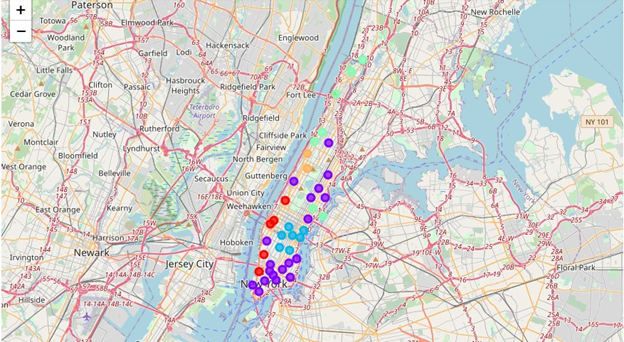

In the observations noted from the map in the ‘results’ section, we are going to focus our attention on cluster 1. While it had a high frequency of BBQ joints (as did all the other clusters with some having even higher frequencies), it had a much lower frequency of wings joints compared to the other clusters. The neighborhoods represented in cluster 1 are Lincoln Square, Clinton, Tribeca, West Village, and Hudson Yards. Of those 5 neighborhoods, the one with the fewest barbecue restaurants is Lincoln Square with 12 obtained by the chart we generated in the ‘data’ section. Additionally, there aren’t even any wings joints in the top 10 most common venues in this neighborhood. All the other neighborhoods in this cluster (and all the others) have either a high frequency of BBQ joints and/or wings joints in their top 10 most frequent venues. This represents a great opportunity and high potential for there to be a BBQ restaurant that focuses on selling chicken wings as its main product.

## Conclusion

We began this project asking the question: Which neighborhood in the Manhattan borough of New York City would be best for opening a new barbecue restaurant? As we analyzed the frequency of such restaurants in Manhattan, we quickly discovered that barbecue restaurants tend to be the most popular venue in each neighborhood. This is likely partially due to the fact the term ‘BBQ Joint’ is a very general restaurant category. Thus, we refined our focus and decided to look in a more specific direction in opening a barbecue restaurant that sells wings as its main product due to lower market saturation and competition.  Through data analysis, data wrangling, and machine learning, we found that the neighborhood that displayed the lowest volume of barbecue restaurants and by far the lowest volume of wings restaurants, was Lincoln Square. Based on location data, this seems to be the optimal location in the Manhattan for building a new barbecue restaurant that sells wings as its main product. However, stakeholders should also obtain further information focusing on those neighborhoods examined in cluster 1 in the results section since that cluster of neighborhoods was by far the most promising. Information such as the attractiveness of each location (proximity to parks and water), socioeconomic data, and real estate prices should also be examined before developers move forward in making this decision.